In [1]:
import sys
sys.path.append('../')
from config import *
from src.realtime_utils import *

In [42]:
from plotnine import *

In [3]:
forecast_date1 = '2023-10-05'
forecast_date2 = '2024-01-11'
forecast_date3 = '2024-04-11'

In [66]:
forecast_dates = ['2023-10-05', '2024-01-11', '2024-04-11', '2024-09-22']

In [10]:
# ts_latest = load_latest_series('sari')
# ts_latest = ts_latest['icosari-sari-DE']

In [22]:
ts_final = load_target_series('sari', '2024-09-22', age_group='00+')

In [11]:
ts1 = load_target_series('sari', forecast_date1, age_group='00+')
ts2 = load_target_series('sari', forecast_date2, age_group='00+')
ts3 = load_target_series('sari', forecast_date3, age_group='00+')

<Axes: xlabel='date'>

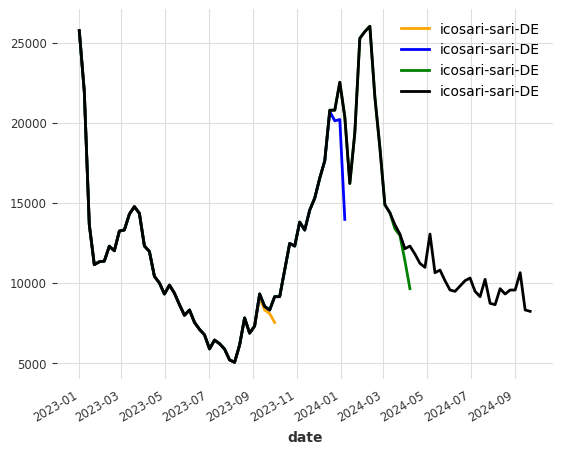

In [23]:
ts1.plot(color='orange')
ts2.plot(color='blue')
ts3.plot(color='green')
ts_final.plot(color='black')

In [67]:
dfs = []
for f in forecast_dates:
    ts = load_target_series('sari', f, age_group='00+')
    df = ts.pd_dataframe().reset_index()
    df['forecast_date'] = f
    dfs.append(df)

df = pd.concat(dfs)
df = df.rename(columns={'icosari-sari-DE': 'value'})

In [101]:
nowcasts = []
for f in forecast_dates[:-1]:
    df_temp = pd.read_csv(f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/refs/heads/main/submissions/icosari/sari/KIT-simple_nowcast/{f}-icosari-sari-KIT-simple_nowcast.csv')
    nowcasts.append(df_temp)
df_nowcast = pd.concat(nowcasts)

In [114]:
def load_nowcast_wide(date, location="DE", age_group="00+"):
    # Construct the file path
    file_path = f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/refs/heads/main/submissions/icosari/sari/KIT-simple_nowcast/{date}-icosari-sari-KIT-simple_nowcast.csv'
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Filter based on location, age_group, and type
    df_filtered = df[
        (df['location'] == location) & 
        (df['age_group'] == age_group) & 
        (df['type'] == "quantile")
    ]
    
    # Pivot the dataframe: quantile values will become columns with "quantile_" as a prefix
    df_wide = df_filtered.pivot(
        index=['location', 'age_group', 'target_end_date', 'forecast_date', 'horizon'],  # Relevant index columns
        columns='quantile',  # Column to pivot on
        values='value'  # The column containing the values to pivot
    )
    
    # Rename columns to add "quantile_" prefix
    df_wide.columns = [f'quantile_{col}' for col in df_wide.columns]
    
    # Reset index to turn index columns back to normal columns (optional)
    df_wide = df_wide.reset_index()
    
    return df_wide

In [117]:
nowcasts = []
for f in forecast_dates[:-1]:
    df_temp = load_nowcast_wide(f)
    nowcasts.append(df_temp)
df_nowcast = pd.concat(nowcasts)

In [119]:
alphas = {"50%": 0.7, "95%": 0.4}

In [121]:
df_nowcast.columns

Index(['location', 'age_group', 'target_end_date', 'forecast_date', 'horizon',
       'quantile_0.025', 'quantile_0.1', 'quantile_0.25', 'quantile_0.5',
       'quantile_0.75', 'quantile_0.9', 'quantile_0.975'],
      dtype='object')

In [144]:
p = (ggplot(df) +
    geom_vline(
         data=pd.DataFrame({'date': [pd.Timestamp(f) for f in forecast_dates]}),
         mapping=aes(xintercept='date', linetype='"Forecast date"'),
         color="black"
     ) +
     geom_line(aes(x='date', y='value', color='forecast_date')) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.025', ymax='quantile_0.975', group='forecast_date', alpha='"95%"'),
         fill="#87CEEB" # skyblue3
     ) +
     geom_ribbon(
         data=df_nowcast,
         mapping=aes(x='target_end_date', ymin='quantile_0.25', ymax='quantile_0.75', group='forecast_date', alpha='"50%"'),
         fill="#87CEEB"
     ) +
     geom_line(
         data=df_nowcast,
         mapping=aes(x='target_end_date', y='quantile_0.5', group='forecast_date'),
         color="#87CEEB", linetype="solid"
     ) +
     theme_bw() +
     labs(x='', y='SARI incidence', color='Data version', linetype='', alpha='Nowcasts with\nprediction intervals') +
     scale_color_manual(values=["#009E73", "#E69F00", "#D55E00", "#000000"], guide=guide_legend(order=1)) +
     scale_linetype_manual(values={'Forecast date': "dotted"}) +
     scale_alpha_manual(name="Nowcasts with \nprediction intervals:", values=alphas)
     # theme(
     #     legend_position="right",
     #     legend_title=element_text(size=9),
     #     legend_text=element_text(size=8),
     #     legend_key_size=0.65,
     #     axis_title_y=element_text(size=9),
     #     axis_text=element_text(size=8),
     #     axis_ticks=element_line(color="black", size=0.25),
     #     panel_grid_major=element_line(size=0.15),
     #     panel_grid_minor=element_line(size=0.1),
     #     #plot_margin=(1, 1.5, 0, 1.5),
     #     legend_margin=5,
     #     legend_box_spacing=0
     # )  
)

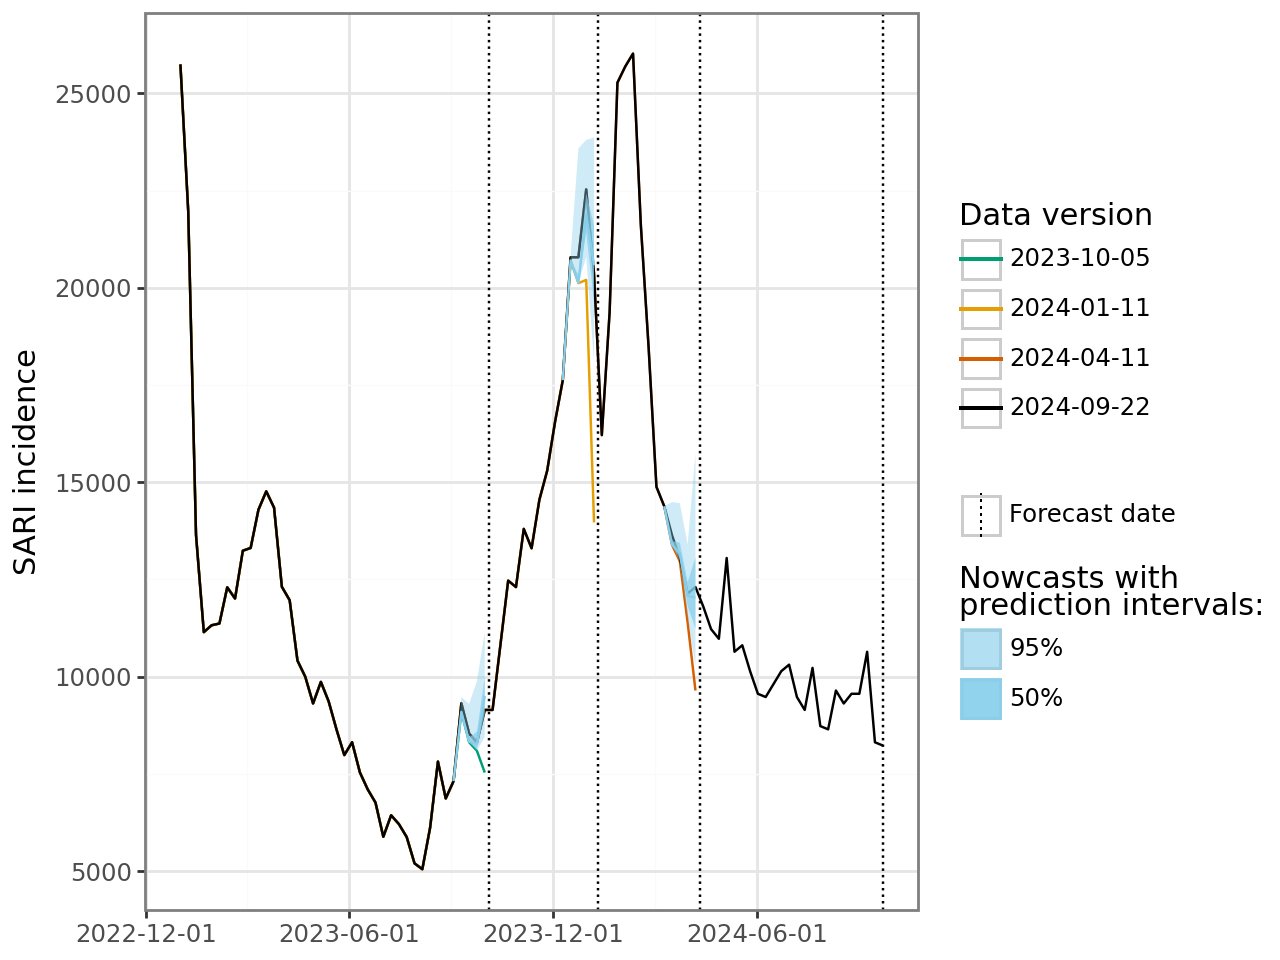

In [145]:
p.show()

In [146]:
p.save("../figures/example.pdf", width = 190.5, height = 90, units="mm", dpi=300)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 190.5 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/example.pdf
